In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
import os
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper

from tensorflow.keras.backend import int_shape

Num GPUs: 1
Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
dimension = (64,64)
channels = 5
optimizer = Adam( lr = 1e-5 )
tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)
                           
def zeroInflatedPoisson(output):
        rate = tf.math.exp(output[0,:,:,0]) #A 
        s = tf.math.sigmoid(output[0,:,:,1])
        components = [tfd.Deterministic(loc=tf.zeros_like(rate)), #E
         tfd.Poisson(rate=rate) #F 
         ]
        mixture = tfd.Mixture(
              cat=tfd.Categorical(probs=tf.stack([1-s, s],axis=-1)),#D
              components=components)
        return mixture

def lstmLayer(inp,filters = [20,20]):

    shape_inp = int_shape(inp)


    lstm_shape = Reshape((shape_inp[-1],shape_inp[1],shape_inp[2],1))(inp)
    

    lstm_conv = ConvLSTM2D(filters=filters[0], kernel_size=(3, 3), activation='relu',
                       padding='same', return_sequences=True,data_format='channels_last')(lstm_shape)
    
    lstm_conv = BatchNormalization() (lstm_conv)

    for i in filters[1:-1]:
        lstm_conv = ConvLSTM2D(filters=i, kernel_size=(3, 3), activation='relu',
                       padding='same', return_sequences=True,data_format='channels_last')(lstm_conv)
        lstm_conv = BatchNormalization() (lstm_conv)

    lstm_conv = ConvLSTM2D(filters=filters[-1], kernel_size=(3, 3), activation='relu',
                       padding='same', return_sequences=False,data_format='channels_last')(lstm_conv)
    lstm_conv = BatchNormalization() (lstm_conv)

    return lstm_conv




def testnet_LSTM_Meets_Unet_Upconv_Poisson(input_shape,
                    n_predictions=1,
                    simpleclassification=None,
                    flatten_output=False,
                    activation_hidden="relu",
                    activation_output="relu"):


    def zeroInflatedPoisson(output):
        rate = tf.math.exp(output[0,:,:,0]) #A 
        s = tf.math.sigmoid(output[0,:,:,1])
        components = [tfd.Deterministic(loc=tf.zeros_like(rate)), #E
         tfd.Poisson(rate=rate) #F 
         ]
        mixture = tfd.Mixture(
              cat=tfd.Categorical(probs=tf.stack([1-s, s],axis=-1)),#D
              components=components)
        return mixture

    def poss(output):
        rate = tf.math.exp(output)
        return tfp.layers.IndependentPoisson(rate)
    
    inputs = Input(shape=input_shape)


    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       
    conv01 = Activation(activation_hidden)(conv01)
    conv01 = BatchNormalization() (conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            
    

    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  
    conv02 = Activation(activation_hidden)(conv02)
    conv02 = BatchNormalization() (conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            
    
    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  
    conv03 = Activation(activation_hidden)(conv03)
    conv03 = BatchNormalization() (conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            
    

    lstm_conv3 = lstmLayer(conv03,filters = [20,20,20])
    lstm_conv3 = BatchNormalization() (lstm_conv3)
    conv03 = concatenate([conv03, lstm_conv3], axis=3)

    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  
    conv04 = Activation(activation_hidden)(conv04)
    conv04 = BatchNormalization() (conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            
    

    lstm_conv4 = lstmLayer(conv04,filters = [20,20,20,20])
    lstm_conv4 = BatchNormalization() (lstm_conv4)

    conv04 = concatenate([conv04, lstm_conv4], axis=3)

    ### UPSAMPLING:
    up04 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(conv04_pool)    
    up04 = BatchNormalization() (up04)
    up04 = concatenate([conv04, up04], axis=3)  
    up04 = Conv2D(20, kernel_size=(3, 3), padding="same")(up04)  
    

    up03 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(up04)           
    up03 = BatchNormalization() (up03)
    up03 = concatenate([conv03, up03], axis=3)  
    up03 = Conv2D(20, kernel_size=(3, 3), padding="same")(up03)  
    

    up02 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(up03)           
    up02 = BatchNormalization() (up02)
    up02 = concatenate([conv02, up02], axis=3)  
    up02 = Conv2D(20, kernel_size=(3, 3), padding="same")(up02)  
    

    up01 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(up02)           
    up01 = BatchNormalization() (up01)
    up01 = concatenate([conv01, up01], axis=3)  
    up01 = Conv2D(20, kernel_size=(3, 3), padding="same")(up01)  
    
    output = Conv2D(64, (1, 1), activation=tf.exp)(up01) 
    
    
    #output = tfp.layers.DistributionLambda(zeroInflatedPoisson)(output)
    output = tfp.layers.DistributionLambda(tfp.distributions.Poisson)(output)
    #output = tfp.layers.DistributionLambda(poss)(output)
    #output = tfp.layers.IndependentPoisson()(output)

    model = Model(inputs=inputs, outputs=output)

    return model

"""
def testnet_LSTM_Meets_Unet_Upconv_Poisson(input_shape,
                    n_predictions=1,
                    simpleclassification=None,
                    flatten_output=False,
                    activation_hidden="relu",
                    activation_output="relu"):

    
    inputs = Input(shape=input_shape)


    conv01 = Conv2D(64, kernel_size=(3, 3), padding="same")(inputs)       
    conv01 = Activation(activation_hidden)(conv01)
    conv01 = BatchNormalization() (conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            


    conv02 = Conv2D(256, kernel_size=(3, 3), padding="same")(conv01_pool)  
    conv02 = Activation(activation_hidden)(conv02)
    conv02 = BatchNormalization() (conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            

    conv03 = Conv2D(512, kernel_size=(3, 3), padding="same")(conv02_pool)  
    conv03 = Activation(activation_hidden)(conv03)
    conv03 = BatchNormalization() (conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            


    #lstm_conv3 = lstmLayer(conv03,filters = [20,20])
    lstm_conv3 = conv03
    lstm_conv3 = BatchNormalization() (lstm_conv3)
    conv03 = concatenate([conv03, lstm_conv3], axis=3)

    conv04 = Conv2D(1024, kernel_size=(3, 3), padding="same")(conv03_pool)  
    conv04 = Activation(activation_hidden)(conv04)
    conv04 = BatchNormalization() (conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            


    lstm_conv4 = conv04
    #lstm_conv4 = lstmLayer(conv04,filters = [20,20,20,20])
    lstm_conv4 = BatchNormalization() (lstm_conv4)

    conv04 = concatenate([conv04, lstm_conv4], axis=3)

    ### UPSAMPLING:
    up04 = Conv2DTranspose(512,(3, 3),strides=(2,2),padding="same")(conv04_pool)    
    up04 = BatchNormalization() (up04)
    up04 = concatenate([conv04, up04], axis=3)  
    up04 = Conv2D(512, kernel_size=(3, 3), padding="same")(up04)  


    up03 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(up04)           
    up03 = BatchNormalization() (up03)
    up03 = concatenate([conv03, up03], axis=3)  
    up03 = Conv2D(256, kernel_size=(3, 3), padding="same")(up03)  


    up02 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(up03)           
    up02 = BatchNormalization() (up02)
    up02 = concatenate([conv02, up02], axis=3)  
    up02 = Conv2D(128, kernel_size=(3, 3), padding="same")(up02)  


    up01 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(up02)           
    up01 = BatchNormalization() (up01)
    up01 = concatenate([conv01, up01], axis=3)  
    up01 = Conv2D(64, kernel_size=(3, 3), padding="same")(up01)  

    output = Conv2D(1, (1, 1), activation=tf.exp)(up01) 
    
    #output = tfp.layers.IndependentPoisson(1)(output)
    output = tfp.layers.DistributionLambda(zeroInflatedPoisson)(output)


    model = Model(inputs=inputs, outputs=output)

    return model
"""

def provideData(flatten=False,dimension=dimension,batch_size=10,transform=None,preTransformation=None):

    getDataSet(DatasetFolder,year=[2017],username=USRN,pswd=PSWD)
    train,test = dataWrapper(PathToData,
                            dimension=dimension,
                            channels=channels,
                            batch_size=batch_size,
                            overwritecsv=True,
                            flatten=flatten,
                            onlyUseYears=[2017],
                            transform=transform,
                            preTransformation=preTransformation)
    
    return train,test
DatasetFolder = "./Data/RAW"
PathToData = os.path.join(DatasetFolder,"MonthPNGData")

In [3]:
dimension = (64,64)
channels = 5
optimizer = Adam( lr = 1e-5 )
tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

train, test = provideData(flatten=False,dimension=dimension,batch_size=1,transform=None,preTransformation=None)

Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 


In [4]:
t_0 = Trainer(testnet_LSTM_Meets_Unet_Upconv_Poisson,
                    NLL,
                    (train,test),
                    batch_size = 1,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])

print("len train,val",len(train),len(test))

[Load file failed]  ./model_data/testnet_LSTM_Meets_Unet_Upconv_Poisson_function/testnet_LSTM_Meets_Unet_Upconv_Poisson_function64x64x5.h5
[Load file failed]  ./model_data/testnet_LSTM_Meets_Unet_Upconv_Poisson_function/testnet_LSTM_Meets_Unet_Upconv_Poisson_function64x64x5history.json
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 10)   460         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 10)   0           conv2d[0][0]                     
_____

In [5]:
t_0.fit(100)
model_0 = t_0.model


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/100
10/10 [==============================] - 18s 2s/step - loss: 1.4278 - mse: 21.1909 - mae: 1.3337 - val_loss: 11.4935 - val_mse: 182.2261 - val_mae: 4.5412
Epoch 2/100
10/10 [==============================] - 3s 336ms/step - loss: 1.4136 - mse: 16.1237 - mae: 1.3222 - val_loss: 10.6583 - val_mse: 160.3905 - val_mae: 4.3161
Epoch 3/100
10/10 [==============================] - 3s 337ms/step - loss: 1.4078 - mse: 11.8709 - mae: 1.3132 - val_loss: 11.0938 - val_mse: 171.4762 - val_mae: 4.4332
Epoch 4/100
10/10 [==============================] - 3s 337ms/step - loss: 1.3968 - mse: 11.3257 - mae: 1.3053 - val_loss: 11.4109 - val_mse: 179.4420 - val_mae: 4.5189
Epoch 5/100
10/10 [==============================] - 3s 346ms/step - loss: 1.3923 - mse: 9.0486 - mae: 1.2969 - val_loss: 11.0874 - val_mse: 171.4421 - val_mae: 4.4307
Epoch 6/100
10/10 [==============================] - 3s 339ms/step

10/10 [==============================] - 3s 343ms/step - loss: 1.2337 - mse: 3.4365 - mae: 1.1506 - val_loss: 141.5592 - val_mse: 3619882240.0000 - val_mae: 133.9679
Epoch 49/100
10/10 [==============================] - 3s 339ms/step - loss: 1.2311 - mse: 3.4104 - mae: 1.1482 - val_loss: 7073.1893 - val_mse: 5493013086208.0000 - val_mae: 7065.4570
Epoch 50/100
10/10 [==============================] - 3s 336ms/step - loss: 1.2288 - mse: 3.4060 - mae: 1.1456 - val_loss: 51296415.0096 - val_mse: 6774902842192025354240.0000 - val_mae: 51296408.0000
Epoch 51/100
10/10 [==============================] - 3s 342ms/step - loss: 1.2271 - mse: 3.3758 - mae: 1.1439 - val_loss: 9803177155847.4961 - val_mse: inf - val_mae: 9803176869888.0000
Epoch 52/100
10/10 [==============================] - 3s 338ms/step - loss: 1.2199 - mse: 3.3082 - mae: 1.1399 - val_loss: 920995523353384.6250 - val_mse: inf - val_mae: 920995405758464.0000
Epoch 53/100
10/10 [==============================] - 3s 337ms/step - l

10/10 [==============================] - 3s 346ms/step - loss: 1.1502 - mse: 2.9257 - mae: 1.0794 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 99/100
10/10 [==============================] - 3s 344ms/step - loss: 1.1485 - mse: 2.9045 - mae: 1.0781 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 100/100
10/10 [==============================] - 3s 334ms/step - loss: 1.1493 - mse: 2.9309 - mae: 1.0789 - val_loss: nan - val_mse: nan - val_mae: nan


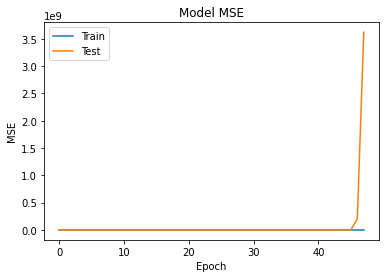

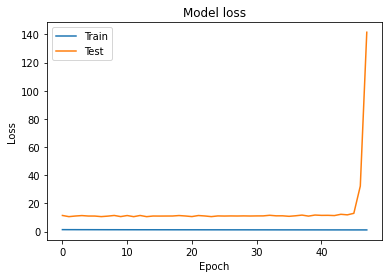

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history_0 = t_0.history
def plotHistory(history):
    # Plot training & validation accuracy values
    plt.plot(history['mse'][:48])
    plt.plot(history['val_mse'][:48])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'][:48])
    plt.plot(history['val_loss'][:48])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory(history_0)

In [7]:
def testnet_LSTM_Meets_Unet_Upconv_Poisson_changed_CHANNEL(input_shape,
                    n_predictions=1,
                    simpleclassification=None,
                    flatten_output=False,
                    activation_hidden="relu",
                    activation_output="relu"):


    def zeroInflatedPoisson(output):
        rate = tf.math.exp(output[0,:,:,0]) #A 
        s = tf.math.sigmoid(output[0,:,:,1])
        components = [tfd.Deterministic(loc=tf.zeros_like(rate)), #E
         tfd.Poisson(rate=rate) #F 
         ]
        mixture = tfd.Mixture(
              cat=tfd.Categorical(probs=tf.stack([1-s, s],axis=-1)),#D
              components=components)
        return mixture

    def poss(output):
        rate = tf.math.exp(output)
        return tfp.layers.IndependentPoisson(rate)
    
    inputs = Input(shape=input_shape)


    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       
    conv01 = Activation(activation_hidden)(conv01)
    conv01 = BatchNormalization() (conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            
    

    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  
    conv02 = Activation(activation_hidden)(conv02)
    conv02 = BatchNormalization() (conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            
    
    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  
    conv03 = Activation(activation_hidden)(conv03)
    conv03 = BatchNormalization() (conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            
    

    lstm_conv3 = lstmLayer(conv03,filters = [20,20,20])
    lstm_conv3 = BatchNormalization() (lstm_conv3)
    conv03 = concatenate([conv03, lstm_conv3], axis=3)

    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  
    conv04 = Activation(activation_hidden)(conv04)
    conv04 = BatchNormalization() (conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            
    

    lstm_conv4 = lstmLayer(conv04,filters = [20,20,20,20])
    lstm_conv4 = BatchNormalization() (lstm_conv4)

    conv04 = concatenate([conv04, lstm_conv4], axis=3)

    ### UPSAMPLING:
    up04 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(conv04_pool)    
    up04 = BatchNormalization() (up04)
    up04 = concatenate([conv04, up04], axis=3)  
    up04 = Conv2D(20, kernel_size=(3, 3), padding="same")(up04)  
    

    up03 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(up04)           
    up03 = BatchNormalization() (up03)
    up03 = concatenate([conv03, up03], axis=3)  
    up03 = Conv2D(20, kernel_size=(3, 3), padding="same")(up03)  
    

    up02 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(up03)           
    up02 = BatchNormalization() (up02)
    up02 = concatenate([conv02, up02], axis=3)  
    up02 = Conv2D(20, kernel_size=(3, 3), padding="same")(up02)  
    

    up01 = Conv2DTranspose(20,(3, 3),strides=(2,2),padding="same")(up02)           
    up01 = BatchNormalization() (up01)
    up01 = concatenate([conv01, up01], axis=3)  
    up01 = Conv2D(20, kernel_size=(3, 3), padding="same")(up01)  
    
    output = Conv2D(1, (1, 1), activation=tf.exp)(up01) 
    
    
    #output = tfp.layers.DistributionLambda(zeroInflatedPoisson)(output)
    output = tfp.layers.DistributionLambda(tfp.distributions.Poisson)(output)
    #output = tfp.layers.DistributionLambda(poss)(output)
    #output = tfp.layers.IndependentPoisson()(output)

    model = Model(inputs=inputs, outputs=output)

    return model

In [8]:
t_1 = Trainer(testnet_LSTM_Meets_Unet_Upconv_Poisson_changed_CHANNEL,
                    NLL,
                    (train,test),
                    batch_size = 1,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])

print("len train,val",len(train),len(test))

[Load file failed]  ./model_data/testnet_LSTM_Meets_Unet_Upconv_Poisson_changed_CHANNEL_function/testnet_LSTM_Meets_Unet_Upconv_Poisson_changed_CHANNEL_function64x64x5.h5
[Load file failed]  ./model_data/testnet_LSTM_Meets_Unet_Upconv_Poisson_changed_CHANNEL_function/testnet_LSTM_Meets_Unet_Upconv_Poisson_changed_CHANNEL_function64x64x5history.json
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 10)   460         input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None,

In [9]:
t_1.fit(150)
model_1 = t_1.model

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/150
10/10 [==============================] - 17s 2s/step - loss: 2.7420 - mse: 3634.3413 - mae: 2.6048 - val_loss: 10.6227 - val_mse: 161.3957 - val_mae: 4.3247
Epoch 2/150
10/10 [==============================] - 3s 333ms/step - loss: 2.1355 - mse: 43.3292 - mae: 1.9754 - val_loss: 11.0444 - val_mse: 170.7875 - val_mae: 4.4104
Epoch 3/150
10/10 [==============================] - 3s 339ms/step - loss: 2.0112 - mse: 20.8725 - mae: 1.8445 - val_loss: 11.0379 - val_mse: 169.8374 - val_mae: 4.4048
Epoch 4/150
10/10 [==============================] - 3s 345ms/step - loss: 1.9181 - mse: 14.4605 - mae: 1.7549 - val_loss: 11.1167 - val_mse: 170.9756 - val_mae: 4.4120
Epoch 5/150
10/10 [==============================] - 3s 340ms/step - loss: 1.8844 - mse: 13.4356 - mae: 1.7311 - val_loss: 11.0983 - val_mse: 169.9632 - val_mae: 4.4080
Epoch 6/150
10/10 [==============================] - 3s 335ms/s

10/10 [==============================] - 3s 319ms/step - loss: 1.2554 - mse: 4.3481 - mae: 1.2095 - val_loss: 13.6664 - val_mse: 5813.3584 - val_mae: 6.1701
Epoch 49/150
10/10 [==============================] - 3s 336ms/step - loss: 1.2513 - mse: 4.2433 - mae: 1.2012 - val_loss: 18.4354 - val_mse: 122104.8125 - val_mae: 10.6605
Epoch 50/150
10/10 [==============================] - 3s 336ms/step - loss: 1.2416 - mse: 4.1955 - mae: 1.1985 - val_loss: 58.3670 - val_mse: 10184197.0000 - val_mae: 50.9546
Epoch 51/150
10/10 [==============================] - 3s 348ms/step - loss: 1.2415 - mse: 4.2056 - mae: 1.1889 - val_loss: 326.0223 - val_mse: 1072749056.0000 - val_mae: 318.3076
Epoch 52/150
10/10 [==============================] - 3s 349ms/step - loss: 1.2357 - mse: 4.2369 - mae: 1.1920 - val_loss: 23955017.6308 - val_mse: 11355026015949684736.0000 - val_mae: 23955034.0000
Epoch 53/150
10/10 [==============================] - 3s 343ms/step - loss: 1.2255 - mse: 4.0883 - mae: 1.1887 - val_

10/10 [==============================] - 3s 330ms/step - loss: 1.0594 - mse: 3.1466 - mae: 1.0395 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 98/150
10/10 [==============================] - 3s 327ms/step - loss: 1.0545 - mse: 3.0539 - mae: 1.0347 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 99/150
10/10 [==============================] - 3s 328ms/step - loss: 1.0515 - mse: 2.9551 - mae: 1.0195 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 100/150
10/10 [==============================] - 3s 331ms/step - loss: 1.0486 - mse: 3.0249 - mae: 1.0341 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 101/150
10/10 [==============================] - 3s 332ms/step - loss: 1.0462 - mse: 2.9490 - mae: 1.0205 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 102/150
10/10 [==============================] - 3s 327ms/step - loss: 1.0421 - mse: 2.9756 - mae: 1.0211 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 103/150
10/10 [==============================] - 3s 329ms/step

Epoch 149/150
10/10 [==============================] - 3s 326ms/step - loss: 0.9205 - mse: 2.3966 - mae: 0.9130 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 150/150
10/10 [==============================] - 3s 331ms/step - loss: 0.9207 - mse: 2.3559 - mae: 0.8971 - val_loss: nan - val_mse: nan - val_mae: nan


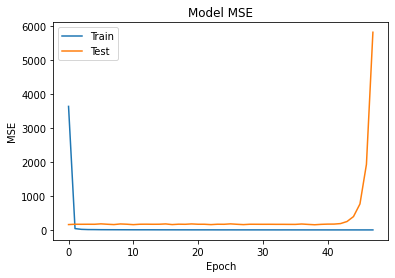

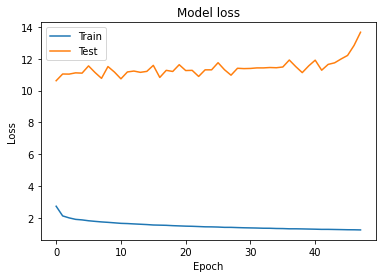

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history_1 = t_1.history

plotHistory(history_1)